### Visión por Computadora I


Jorge Ceferino Valdez

Trabajo Práctico N° 2

- Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.
    1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.
    2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
    3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of
focus measure operators in shape-from-focus”

In [1]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [2]:
# mostrar version de python
print("Version de python: ", sys.version)
# mostrar version de opencv
print("Version de opencv: ", cv2.__version__)

# Version de python:  3.9.18 (main, Sep 11 2023, 13:41:44) 
# [GCC 11.2.0]
# Version de opencv:  4.8.1

Version de python:  3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]
Version de opencv:  4.8.1


### Definimos los filtros en el dominio espectral

### Punto 1

In [3]:
# Usando la libreria de opencv
def create_gauss_filter_cv(h, w, k_size=5, sigma=5):
    # Crear un kernel gaussiano en el dominio espacial
    gauss_kernel = cv2.getGaussianKernel(k_size, sigma)
    
    # Ampliar el kernel para que coincida con las dimensiones deseadas (h, w)
    gauss_kernel = np.outer(gauss_kernel, gauss_kernel.transpose())
    
    # Normalizar el kernel
    gauss_kernel = gauss_kernel / np.sum(gauss_kernel)
    
    # Calcular la transformada de Fourier del kernel gaussiano
    fft_gauss_kernel = np.fft.fft2(gauss_kernel, (h, w))
    #fft_gauss_kernel = np.fft.fftshift(fft_gauss_kernel)
    
    # Retornar el kernel gaussiano o filtro gaussiano de tamaño HxW
    # y su transformada de Fourier
    return gauss_kernel, fft_gauss_kernel

# Usando la libreria de numpy
def create_gauss_filter(h, w, k_size, sigma):
    y, x = np.meshgrid(np.arange(h) - h // 2, np.arange(w) - w // 2, indexing='ij')
    kernel = np.exp(-(x**2 + y**2) / (2. * sigma**2))
    kernel /= kernel.sum()  # Normalizar para que la suma sea 1

    # Zero-padding para obtener el tamaño deseado del kernel
    padded_kernel = np.zeros((h, w))
    padded_kernel[:kernel.shape[0], :kernel.shape[1]] = kernel

    # Calcular la transformada de Fourier del kernel
    fft_kernel = np.fft.fftshift(np.fft.fft2(padded_kernel))

    return padded_kernel, fft_kernel

def apply_filter(image, fft_kernel):
    # Convertir la imagen a escala de grises si es a color
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calcular la transformada de Fourier de la imagen
    fft_image = np.fft.fftshift(np.fft.fft2(image))

    # Aplicar el filtro en el dominio de la frecuencia
    filtered_fft_image = fft_image * fft_kernel

    # Obtener la imagen filtrada en el dominio espacial
    filtered_image = np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_fft_image)))

    return filtered_image.astype(np.uint8)

In [4]:
# Parámetros de ejemplo

# Cargar imagen
#image = cv2.imread('../data/fft_alfa_pred.png', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('../data/enterprise.jpg', cv2.IMREAD_GRAYSCALE)

h, w = image.shape  # Tamaño de la imagen
k_size = 21  # Tamaño del kernel
sigma_values = [0.5, 1, 3, 7, 10]  # Valores de sigma para probar


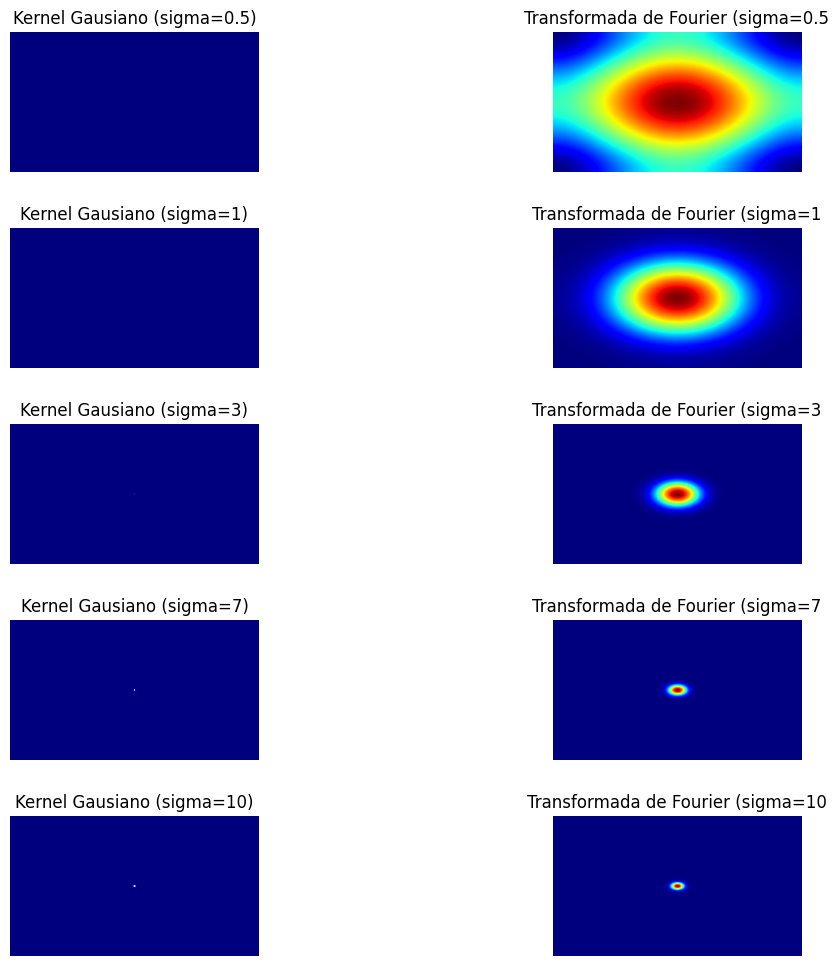

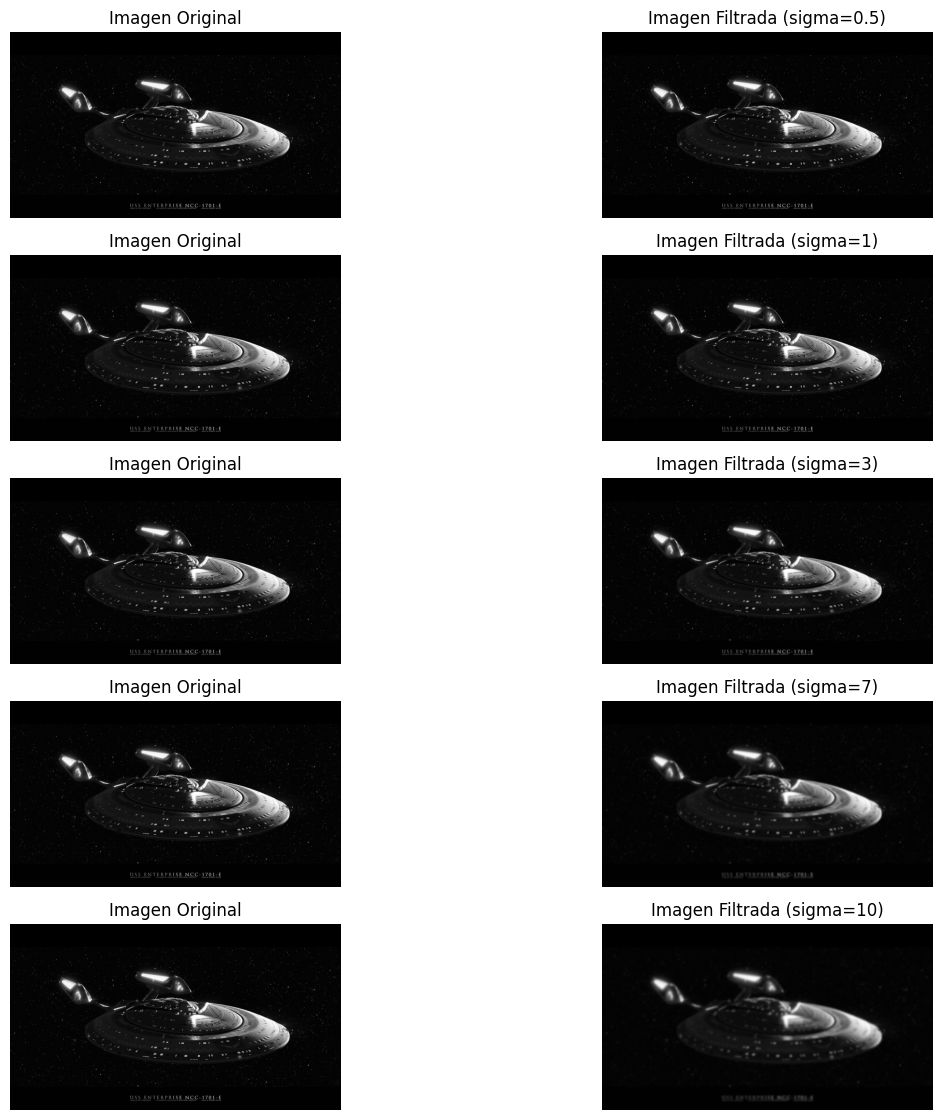

In [5]:
# Crear gráficos para diferentes tamaños de kernel y sigma
plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, sigma in enumerate(sigma_values):
    # Crear filtro gaussiano y obtener su transformada de Fourier
    # Usando la implementación con numpy
    padded_kernel, fft_kernel = create_gauss_filter(h, w, k_size, sigma)

    # Graficar filtro gaussiano en el dominio espacial

    #plt.subplot(1,2,1)
    plt.subplot(len(sigma_values), 2, i*2+1)
    plt.axis('off')
    plt.title(f'Kernel Gausiano (sigma={sigma})')
    plt.imshow(padded_kernel, cmap='jet')    

    # Graficar transformada de Fourier del filtro gaussiano
    plt.subplot(len(sigma_values), 2, i*2+2)
    plt.axis('off')
    plt.title(f'Transformada de Fourier (sigma={sigma}')
    plt.imshow(np.log(np.abs(fft_kernel) + 1), cmap='jet')

# Aplicar filtro a la imagen de ejemplo fuera del bucle
plt.figure(figsize=(14, 14))
filtered_images = []

for sigma in sigma_values:
    _, fft_kernel = create_gauss_filter(h, w, k_size, sigma)
    filtered_image = apply_filter(image, fft_kernel)
    filtered_images.append(filtered_image)

# Visualizar la imagen original y la imagen filtrada para cada sigma
for i, sigma in enumerate(sigma_values):
    plt.subplot(len(sigma_values), 2, i*2+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Imagen Original')
    plt.axis('off')

    filtered_image_shift = np.fft.fftshift(filtered_images[i])
    plt.subplot(len(sigma_values), 2, i*2+2)
    #plt.imshow(filtered_images[i], cmap='gray')
    plt.imshow(filtered_image_shift, cmap='gray')
    plt.title(f'Imagen Filtrada (sigma={sigma})')
    plt.axis('off')

plt.show()

### Punto 2


Similitudes entre el filtrado espectral y el filtrado por convolución:

1. Ambos métodos utilizan la transformada de Fourier: Tanto el filtrado espectral como el filtrado por convolución utilizan la transformada de Fourier para procesar la imagen en el dominio de la frecuencia.

2. Aplicación de operaciones en el dominio de la frecuencia: Ambos métodos realizan operaciones en el dominio de la frecuencia, lo que permite manipular las características de la imagen en términos de su contenido de frecuencia.

Diferencias entre el filtrado espectral y el filtrado por convolución:

1. Enfoque de procesamiento: El filtrado espectral se centra en el filtrado de la imagen en el dominio de la frecuencia mediante el uso de un filtro en el espacio de la frecuencia (FFT), mientras que el filtrado por convolución se enfoca en aplicar una operación de convolución directamente en la imagen en el dominio del espacio.

2. Naturaleza del filtro: En el filtrado espectral, se utiliza un filtro Gaussiano en el dominio de la frecuencia para suavizar la imagen, mientras que en el filtrado por convolución, no se define explícitamente un filtro, sino que se realizan operaciones en el dominio de la frecuencia y del espacio para calcular ciertas métricas de calidad de imagen.

3. Aplicación específica: El filtrado espectral se usa comúnmente para aplicar filtros específicos, como el filtro Gaussiano, el filtro de paso alto, etc., mientras que el filtrado por convolución puede utilizarse para una variedad de propósitos, incluida la detección de bordes, el desenfoque, etc.

En resumen, ambos métodos comparten la utilización de la transformada de Fourier para procesar imágenes en el dominio de la frecuencia, pero difieren en sus enfoques de procesamiento y en la naturaleza de los filtros utilizados. El filtrado espectral se centra en aplicar filtros específicos en el dominio de la frecuencia, mientras que el filtrado por convolución se enfoca en realizar operaciones directas en el dominio del espacio.

In [6]:
# Función para crear un filtro de convolución de tamaño kernel_size x kernel_size
def create_convolutional_filter(kernel_size):
    # Creamos un filtro de convolución de tamaño kernel_size x kernel_size con valores aleatorios
    filter = np.random.rand(kernel_size, kernel_size)

    # Normalizamos los valores para que la suma de todos los elementos del filtro sea igual a 1
    filter /= np.sum(filter)

    return filter

# Función para aplicar un filtro de convolución a una imagen en escala de grises
def apply_convolutional_filter(image, filter):
    # Obtenemos las dimensiones de la imagen y del filtro
    image_height, image_width = image.shape
    filter_height, filter_width = filter.shape

    # Calculamos el tamaño del padding para mantener el tamaño de la imagen original después de aplicar el filtro
    pad_height = filter_height // 2
    pad_width = filter_width // 2

    # Aplicamos zero-padding a la imagen
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    # Creamos una matriz para almacenar la imagen filtrada
    filtered_image = np.zeros_like(image)

    # Aplicamos el filtro de convolución
    for i in range(image_height):
        for j in range(image_width):
            # Extraemos la región de la imagen que corresponde al área del filtro
            region = padded_image[i:i+filter_height, j:j+filter_width]

            # Realizamos la convolución entre el filtro y la región de la imagen
            filtered_image[i, j] = np.sum(region * filter)
            
    return filtered_image

In [7]:
# Funcion para calcular la calidad de una imagen
# Extraida del paper
def calcular_calidad_imagen(input_image):
    # Calcular los coeficientes de Fourier de la imagen
    fourier_coefficients = np.fft.fftshift(np.fft.fft2(input_image)) 

    # Calcular el valor absoluto de todos los coeficientes de Fourier
    abs_values = np.abs(fourier_coefficients)

    # Calcular el valor máximo entre todos los coeficientes
    maximum_value = np.max(abs_values)

    # Calcular el número total de coeficientes que son mayores que
    # el valor máximo / 1000
    total = abs_values[abs_values > maximum_value / 1000].size

    # Calcular la calidad de la imagen como el número total de coeficientes 
    # dividido por el tamaño de la imagen
    result = total / input_image.size

    return result

In [8]:
#Alto

In [16]:
image_p2 = cv2.imread('../data/jaylah.jpeg')

# Convertir la imagen a escala de grises
gray_image = cv2.cvtColor(image_p2, cv2.COLOR_BGR2GRAY)

h, w = gray_image.shape  # Tamaño de la imagen
k_size = 3  # Tamaño del kernel o filtro
sigma = 5  # Valor de sigma para probar

> Probare el filtro convolucional en una imagen y guardare la imagen resultante para luego calcular la calidad de la imagen.

> Empleare el mismo tamaño de kernel y sigma para los dos métodos de filtrado.

In [17]:
# Creamos un filtro de convolución de tamaño k_size x k_size
conv_filter = create_convolutional_filter(k_size)

# Aplicamos el filtro de convolución a la imagen en escala de grises
filtered_image_conv = apply_convolutional_filter(gray_image, conv_filter)

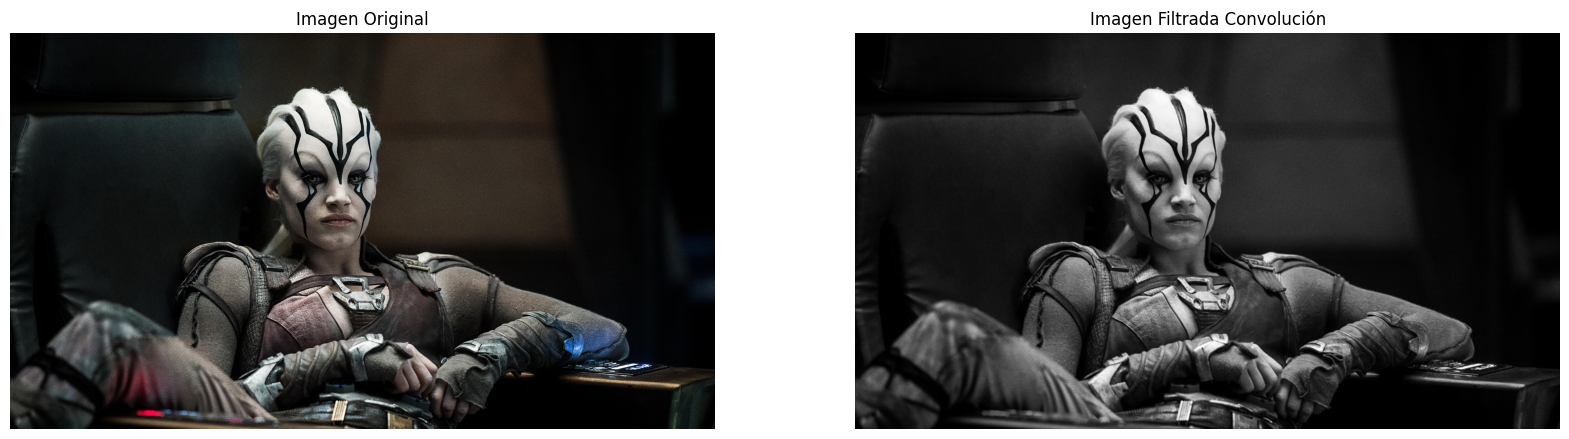

In [18]:

# Mostramos la imagen original y la imagen filtrada
plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_p2, cv2.COLOR_BGR2RGB))
plt.title('Imagen Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image_conv, cmap='gray')
plt.title('Imagen Filtrada Convolución')
plt.axis('off')

plt.show()

> Ahora probare el filtro gaussiano y guardare la imagen resultante para luego calcular la calidad de la imagen

In [19]:
padded_kernel, fft_kernel = create_gauss_filter(h, w, k_size, sigma)
filtered_image_gauss = apply_filter(gray_image, fft_kernel)

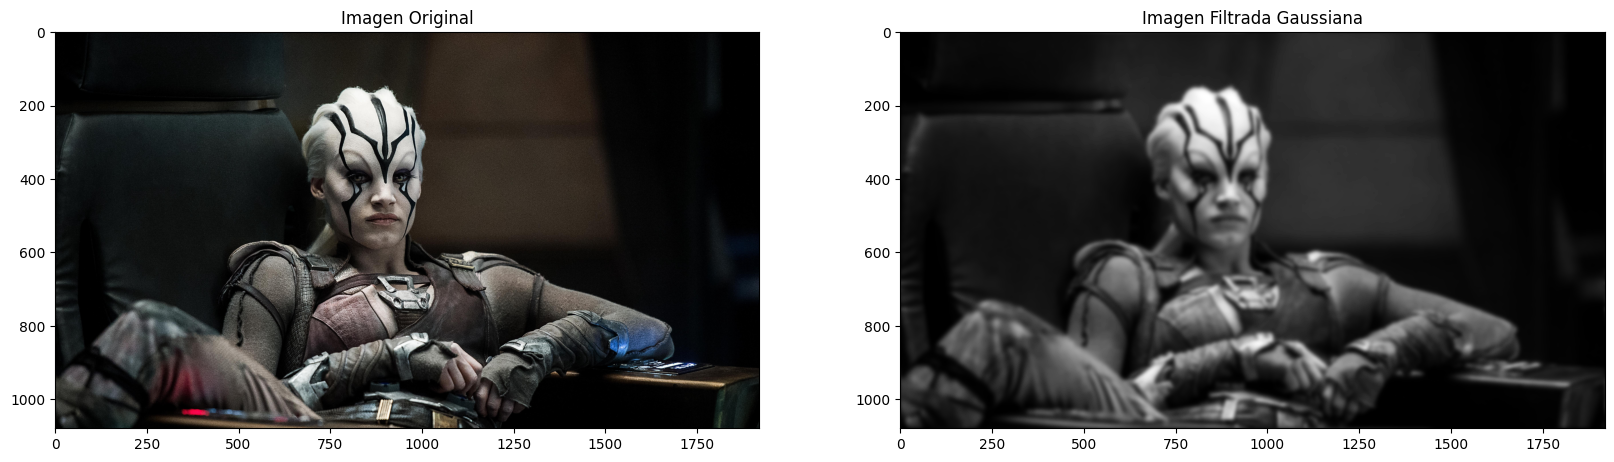

In [20]:
# Visualizar la imagen original y la imagen filtrada
plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_p2, cv2.COLOR_BGR2RGB))
plt.title('Imagen Original')

filtered_image_gauss_shift = np.fft.fftshift(filtered_image_gauss)
plt.subplot(1, 2, 2)
plt.imshow(filtered_image_gauss_shift, cmap='gray') 
plt.title('Imagen Filtrada Gaussiana')

plt.show()

Calculo la calidad de las imagenes resultantes.

In [21]:
# Calculo la calidad de cada imagen
calidad_conv = calcular_calidad_imagen(filtered_image_conv)
calidad_gauss = calcular_calidad_imagen(filtered_image_gauss_shift)

In [22]:
print(f'Calidad de la imagen filtrada con filtro convolucional: {calidad_conv}')
print(f'Calidad de la imagen filtrada con filtro gaussiano: {calidad_gauss}')


Calidad de la imagen filtrada con filtro convolucional: 0.014953221450617284
Calidad de la imagen filtrada con filtro gaussiano: 0.004714988425925926


#### Al aplicar un filtro convolucional con el mismo tamaño de kernel que el Gaussiano se obtiene una imagen menos difuminada. Por lo que al comparar las imagenes resultantes, la convolucional tiene mejor calidad. Sin embargo, el filtro convolucional tarda mas.